## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)


In [5]:
len(fmnist_dataset_test)

10000

In [12]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        prob = torch.zeros(y.shape[0], 10)
        prob[torch.arange(y.shape[0]), y] = 1
        if torch.cuda.is_available():
            X = X.cuda()
            prob = prob.cuda()
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, prob)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    clear_output(wait=True)

In [14]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            prob = torch.zeros(y.shape[0], 10)
            prob[torch.arange(y.shape[0]), y] = 1
            if torch.cuda.is_available():
                X = X.cuda()
                prob = prob.cuda()
            pred = model(X)
            test_loss += loss_fn(pred, prob).item()
            correct += (pred.argmax(1) == prob.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    clear_output(wait=True)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [15]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [16]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


Your experiments come here:

In [17]:
batch_size, learning_rate = 128, 1e-3

model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

In [18]:
epochs = 15

if (torch.cuda.is_available()):
    print("Model will be training on GPU")
    model.cuda()
    loss_func = loss_func.cuda()
else:
    print("Model will be training on CPU")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_func, opt)
    test_loop(test_loader, model, loss_func)
print("Done!")

Test Error: 
 Accuracy: 88.7%, Avg loss: 0.331881 

Done!


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [31]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [32]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
           Dropout-3                  [-1, 512]               0
              ReLU-4                  [-1, 512]               0
            Linear-5                  [-1, 512]         262,656
           Dropout-6                  [-1, 512]               0
              ReLU-7                  [-1, 512]               0
            Linear-8                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 2.55
Estimated Total Size (MB): 2.59
----------------------------------------------------------------


In [33]:
model = OverfittingNeuralNetwork().to(device)
print(model)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

OverfittingNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [34]:
epochs = 60

loss_history, accuracy_history = [], []

if (torch.cuda.is_available()):
    print("Model will be training on GPU")
    model.cuda()
    loss_func = loss_func.cuda()
else:
    print("Model will be training on CPU")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_func, opt)
    loss, acc = test_loop(test_loader, model, loss_func)
    loss_history.append(loss)
    accuracy_history.append(acc)
print("Done!")

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.307496 

Done!


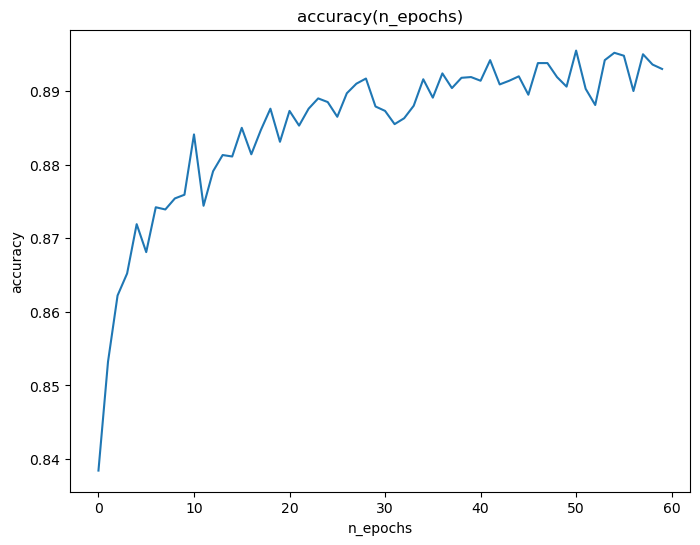

In [35]:
plt.figure(figsize=(8, 6))
plt.plot(accuracy_history)
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.title('accuracy(n_epochs)')
plt.show()

Text(0.5, 1.0, 'loss(n_epochs)')

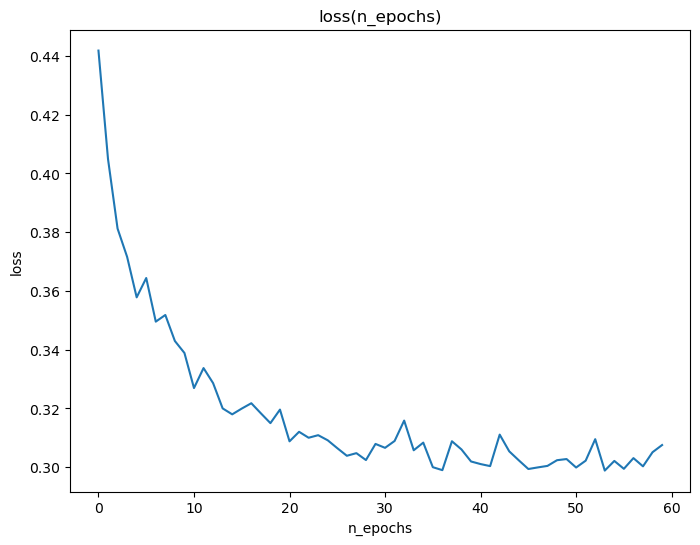

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(loss_history)
plt.xlabel('n_epochs')
plt.ylabel('loss')
plt.title('loss(n_epochs)')

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [37]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [38]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
       BatchNorm1d-3                  [-1, 512]           1,024
           Dropout-4                  [-1, 512]               0
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 512]         262,656
       BatchNorm1d-7                  [-1, 512]           1,024
           Dropout-8                  [-1, 512]               0
              ReLU-9                  [-1, 512]               0
           Linear-10                   [-1, 10]           5,130
Total params: 671,754
Trainable params: 671,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 2.56
Estimated T

In [39]:
model = FixedNeuralNetwork().to(device)
print(model)
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

FixedNeuralNetwork(
  (model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [40]:
epochs = 60

fixed_loss_history, fixed_accuracy_history = [], []

if (torch.cuda.is_available()):
    print("Model will be training on GPU")
    model.cuda()
    loss_func = loss_func.cuda()
else:
    print("Model will be training on CPU")

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_func, opt)
    loss, acc = test_loop(test_loader, model, loss_func)
    fixed_loss_history.append(loss)
    fixed_accuracy_history.append(acc)
print("Done!")

Test Error: 
 Accuracy: 90.6%, Avg loss: 0.307035 

Done!


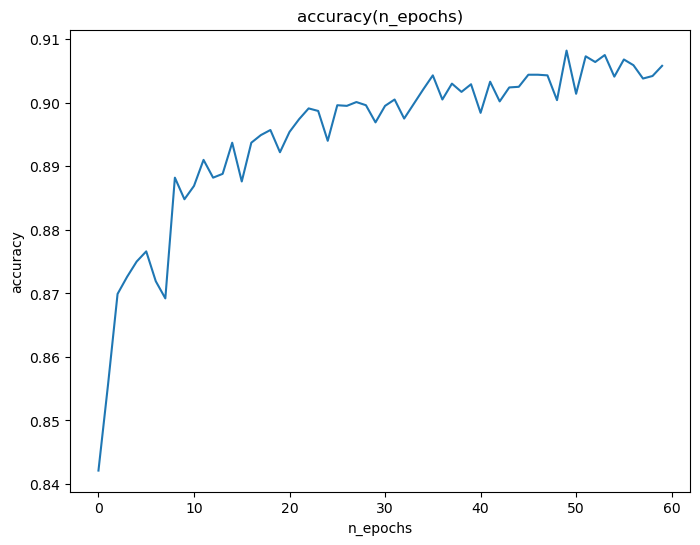

In [41]:
plt.figure(figsize=(8, 6))
plt.plot(fixed_accuracy_history)
plt.xlabel('n_epochs')
plt.ylabel('accuracy')
plt.title('accuracy(n_epochs)')
plt.show()

Text(0.5, 1.0, 'loss(n_epochs)')

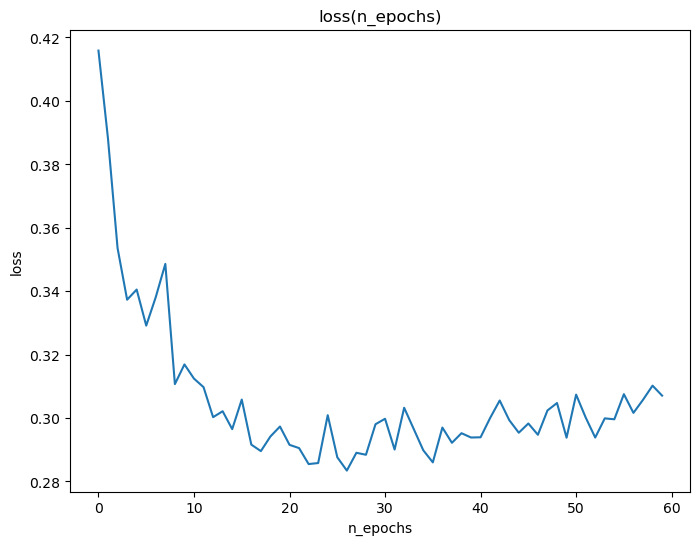

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(fixed_loss_history)
plt.xlabel('n_epochs')
plt.ylabel('loss')
plt.title('loss(n_epochs)')

### Conclusions:
_Write down small report with your conclusions and your ideas._

We used only linear layers, in this problem it is quite difficult to obtain high accuracy of more than 94% using them. Now we know how to deal with overtraining of the model -- we can use special layers like dropout, ignoring some nodes, changing colors (for example, full inversion of colors when training the model), reducing the size (scaling) of pictures, possibly mirroring some images (in the case of our problem such numbers as 0 and 8).